***This notebook is built off of Germano's existing LSCP notebook:

***Objective:  Attempt to solve the Location Coverage Backup Problem as a script and access PuLP manually (outside of PySAL spopt ecosystem)

***Steps:
1)  Solve for LSCP

2)  Retrieve the minimum number of facilities required from LSCP result

3)  Assign this result to variable p and use for defining LpConstraint

In [153]:
from spopt.locate.coverage import LSCP
from spopt.locate.util import simulated_geo_points

import numpy
import geopandas
from pulp import *
import spaghetti
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [154]:
CLIENT_COUNT = 100 # quantity demand points
FACILITY_COUNT = 10 # quantity supply points

MAX_COVERAGE = 8 # maximum service radius in meters

# Random seeds for reproducibility
CLIENT_SEED = 5
FACILITY_SEED = 6

solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)

In [155]:
lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

In [156]:
street = spaghetti.element_as_gdf(ntw, arcs=True)

street_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(street["geometry"].buffer(0.2).unary_union),
    crs=street.crs,
    columns=["geometry"],
)

<AxesSubplot:>

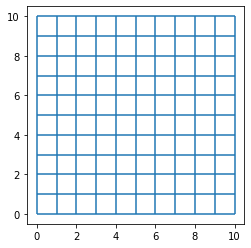

In [157]:
street.plot()

In [158]:
client_points = simulated_geo_points(street_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED)
facility_points = simulated_geo_points(
    street_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

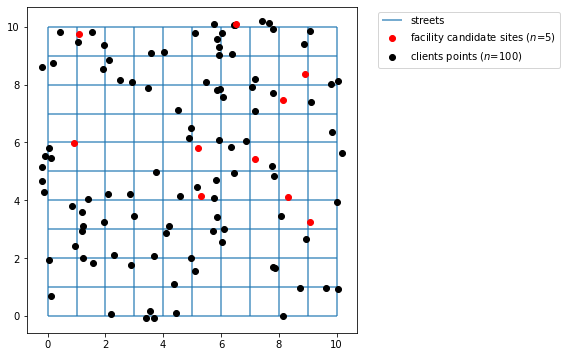

In [159]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facility_points.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=5)')
client_points.plot(ax=ax, color='black', label='clients points ($n$=100)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

In [160]:
ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)

ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

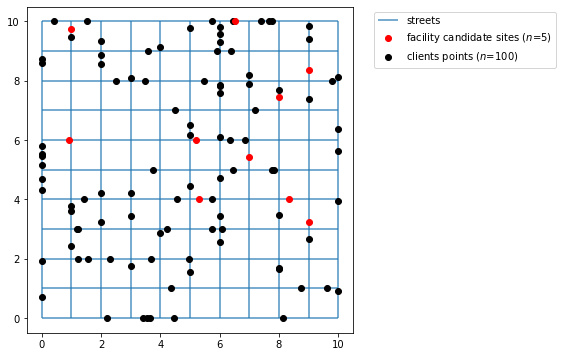

In [161]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facilities_snapped.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=5)')
clients_snapped.plot(ax=ax, color='black', label='clients points ($n$=100)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

In [162]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)

In [163]:
cost_matrix

array([[12.60302601,  3.93598651,  8.16571655,  6.04319467,  5.65607701,
        11.18214123,  7.77728592,  7.39698689,  8.4298727 ,  1.90391589],
       [13.10096347,  4.43392397,  8.66365401,  6.54113213,  5.15813955,
        11.68007869,  7.98645534,  7.89492435,  8.92781016,  1.88691468],
       [ 6.9095462 ,  4.2425067 ,  2.47223674,  0.34971486,  5.34955682,
         5.48866142,  6.20496192,  4.29649292,  2.73639289,  7.5973957 ],
       [ 2.98196832,  7.84581224,  3.45534114,  3.57786302,  6.25374871,
         1.56108354,  4.60165639,  2.69318739,  1.19118499, 11.52497358],
       [ 7.5002892 ,  6.32806975,  4.55779979,  6.43527791, 11.75939222,
         7.57422447, 12.61479732, 10.70632832,  7.67344251, 10.00723109],
       [ 0.60209077, 11.42987132,  5.03940023,  7.16192211,  9.8378078 ,
         2.02297555,  5.71659889,  5.80812989,  4.77524408, 15.10903267],
       [ 5.37335867,  6.20113923,  2.43086927,  4.30834738,  9.6324617 ,
         5.44729395, 10.4878668 ,  8.5793978 

In [164]:
# create an array, mark values with a 1 if <= 8
# all other values marked w/ zero (no coverage)
aij = numpy.zeros(cost_matrix.shape)
aij[cost_matrix <= MAX_COVERAGE] = 1
#! aij is the coverage matrix
aij

array([[0., 1., 0., 1., 1., 0., 1., 1., 0., 1.],
       [0., 1., 0., 1., 1., 0., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0., 1., 0., 0., 1., 0.],
       [1., 0., 1., 1., 0., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0., 1., 0., 0., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 0., 1., 1., 1., 1., 0., 1., 1., 0.],
       [0., 1., 0., 1., 1., 0., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 0., 0., 0., 0., 1., 1.],
       [0., 1., 1., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 0., 0., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 0., 1., 1., 0., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 0., 

All code before this is really just setup... Now with the information we have how can we use the PuLP solver to solve for maximizing backup coverage.

First: solve for LSCP
Second: use p (min # of facilities required) as the minimum required facilites in the LpProblem constraint.

In [165]:
lscp_from_cost_matrix = LSCP.from_cost_matrix(cost_matrix, MAX_COVERAGE)
print(lscp_from_cost_matrix.problem)
lscp_from_cost_matrix.solve(solver)

LSCP:
MINIMIZE
1*x_0_ + 1*x_1_ + 1*x_2_ + 1*x_3_ + 1*x_4_ + 1*x_5_ + 1*x_6_ + 1*x_7_ + 1*x_8_ + 1*x_9_ + 0
SUBJECT TO
_C1: x_1_ + x_3_ + x_4_ + x_6_ + x_7_ + x_9_ >= 1

_C2: x_1_ + x_3_ + x_4_ + x_6_ + x_7_ + x_9_ >= 1

_C3: x_0_ + x_1_ + x_2_ + x_3_ + x_4_ + x_5_ + x_6_ + x_7_ + x_8_ + x_9_ >= 1

_C4: x_0_ + x_1_ + x_2_ + x_3_ + x_4_ + x_5_ + x_6_ + x_7_ + x_8_ >= 1

_C5: x_0_ + x_1_ + x_2_ + x_3_ + x_5_ + x_8_ >= 1

_C6: x_0_ + x_2_ + x_3_ + x_5_ + x_6_ + x_7_ + x_8_ >= 1

_C7: x_0_ + x_1_ + x_2_ + x_3_ + x_5_ + x_8_ >= 1

_C8: x_0_ + x_1_ + x_2_ + x_3_ + x_4_ + x_5_ + x_6_ + x_7_ + x_8_ >= 1

_C9: x_0_ + x_2_ + x_3_ + x_4_ + x_5_ + x_7_ + x_8_ >= 1

_C10: x_1_ + x_3_ + x_4_ + x_9_ >= 1

_C11: x_1_ + x_2_ >= 1

_C12: x_0_ + x_1_ + x_2_ + x_3_ + x_4_ + x_5_ + x_6_ + x_7_ + x_8_ + x_9_ >= 1

_C13: x_1_ + x_2_ + x_3_ + x_8_ + x_9_ >= 1

_C14: x_1_ + x_2_ + x_3_ + x_8_ + x_9_ >= 1

_C15: x_2_ + x_3_ + x_4_ + x_5_ + x_6_ + x_7_ + x_8_ + x_9_ >= 1

_C16: x_1_ + x_2_ + x_3_ + x_4_ + x_6_ + 

In [166]:
dir(lscp_from_cost_matrix)
lscp_from_cost_matrix.fac_vars

[x_0_, x_1_, x_2_, x_3_, x_4_, x_5_, x_6_, x_7_, x_8_, x_9_]

In [167]:
#get the minimum number of facilities needed from result
p = lscp_from_cost_matrix.problem.objective.value()
print(p)

3.0


In [169]:
if lscp_from_cost_matrix.problem.status == -1:
    print("LSCP problem is infeasible, cannot solve for backup coverage!")

In [170]:
# create a LP problem with the method LpProblem in PuLP
del(prob)
prob = LpProblem("LSCP-B", LpMaximize)

In [171]:
#how many clients
range_client = range(cost_matrix.shape[0])

#how many facilities
range_facility = range(cost_matrix.shape[1]) 

In [172]:
# create variables for the facilities, demand nodes, and coverage
fac_vars = [
    LpVariable(
        "facility_{}".format(i), lowBound=0, upBound=1, cat=LpInteger
    )
    for i in range_facility
]
print(fac_vars)

#may not need to be a variable....
dem_vars = [
    LpVariable(
        "demandNode_{}".format(i), lowBound=0, upBound=1, cat=LpInteger
    )
    for i in range_client
]
print(dem_vars)

# coverage variable - this variable should be 1 anytime a demand node is covered > 1x
# i feel like this varibale should be created differently so that it is either assigned 0,1
# based on the coverage status of a demand node
cov_var = [
    LpVariable(
        "coverage_{}".format(i), lowBound=0, upBound=1, cat=LpInteger
    )
    for i in range_client
]
    
print(cov_var)

[facility_0, facility_1, facility_2, facility_3, facility_4, facility_5, facility_6, facility_7, facility_8, facility_9]
[demandNode_0, demandNode_1, demandNode_2, demandNode_3, demandNode_4, demandNode_5, demandNode_6, demandNode_7, demandNode_8, demandNode_9, demandNode_10, demandNode_11, demandNode_12, demandNode_13, demandNode_14, demandNode_15, demandNode_16, demandNode_17, demandNode_18, demandNode_19, demandNode_20, demandNode_21, demandNode_22, demandNode_23, demandNode_24, demandNode_25, demandNode_26, demandNode_27, demandNode_28, demandNode_29, demandNode_30, demandNode_31, demandNode_32, demandNode_33, demandNode_34, demandNode_35, demandNode_36, demandNode_37, demandNode_38, demandNode_39, demandNode_40, demandNode_41, demandNode_42, demandNode_43, demandNode_44, demandNode_45, demandNode_46, demandNode_47, demandNode_48, demandNode_49, demandNode_50, demandNode_51, demandNode_52, demandNode_53, demandNode_54, demandNode_55, demandNode_56, demandNode_57, demandNode_58, dem

In [173]:
#minimum reqired coverage
coverage_min = 2

# this is still quite useful - it describes the relationship between facilities & demand nodes
'''for i in range_client:
    prob += (
        # I should understand the below line better // maybe have them reiterate for me?
        #!lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + cov_var[i]
        lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + cov_var[i]
    )'''

for i in range_client:
    if sum(aij[i]) >= coverage_min: # demand unit has meets coverage requirement
        prob += (
            lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + 1*cov_var[i]
        )
    else: #demand unit does not meet coverage requirement
        prob += (
            lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + 0*cov_var[i]
        )

prob += lpSum(1*i for i in cov_var), "objective function"

#constraints:
#  - the number of facilities chosen should be <= p
#  - all facilities should be either 0 or 1
#  - Ui should be <= 1 

# rhs – numerical value of constraint target, which should be >= p from LSCP result
prob += LpConstraint(sum(fac_vars), sense=LpConstraintEQ, rhs=p, name='Facility Constraint')

print(prob)

LSCP-B:
MAXIMIZE
1*coverage_0 + 1*coverage_1 + 1*coverage_10 + 1*coverage_11 + 1*coverage_12 + 1*coverage_13 + 1*coverage_14 + 1*coverage_15 + 1*coverage_16 + 1*coverage_17 + 1*coverage_18 + 1*coverage_19 + 1*coverage_2 + 1*coverage_20 + 1*coverage_21 + 1*coverage_22 + 1*coverage_23 + 1*coverage_24 + 1*coverage_25 + 1*coverage_26 + 1*coverage_27 + 1*coverage_28 + 1*coverage_29 + 1*coverage_3 + 1*coverage_30 + 1*coverage_31 + 1*coverage_32 + 1*coverage_33 + 1*coverage_34 + 1*coverage_35 + 1*coverage_36 + 1*coverage_37 + 1*coverage_38 + 1*coverage_39 + 1*coverage_4 + 1*coverage_40 + 1*coverage_41 + 1*coverage_42 + 1*coverage_43 + 1*coverage_44 + 1*coverage_45 + 1*coverage_46 + 1*coverage_47 + 1*coverage_48 + 1*coverage_49 + 1*coverage_5 + 1*coverage_50 + 1*coverage_51 + 1*coverage_52 + 1*coverage_53 + 1*coverage_54 + 1*coverage_55 + 1*coverage_56 + 1*coverage_57 + 1*coverage_58 + 1*coverage_59 + 1*coverage_6 + 1*coverage_60 + 1*coverage_61 + 1*coverage_62 + 1*coverage_63 + 1*coverage_64 

In [174]:
prob.solve()
'''print('Coverage Values')   
for i in cov_var:
    print(i,i.varValue)'''

print('\n'+'Total Clients Covered >= 2 Times:', value(prob.objective))

print('\n'+ 'Chosen Facility Values')
for i in fac_vars:
    if i.varValue == 1:
        print(i,i.varValue)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/pysaldev/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/fq/47y89n756hg5n9zwbqd79nhw0000gn/T/b4000f10bab646b4975bca4c80aabd8b-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/fq/47y89n756hg5n9zwbqd79nhw0000gn/T/b4000f10bab646b4975bca4c80aabd8b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 106 COLUMNS
At line 1199 RHS
At line 1301 BOUNDS
At line 1412 ENDATA
Problem MODEL has 101 rows, 110 columns and 772 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 90 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 53 strengthened rows, 0 substitutions
Cgl0004I processed model has 100 rows, 108 columns (108 integer (108 of which binary)) and 761 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial 

In [175]:
prob.status

1